In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("naurosromim/bengali-hate-speech-dataset")

print("Path to dataset files:", path)

100%|██████████| 1.60M/1.60M [00:00<00:00, 88.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/naurosromim/bengali-hate-speech-dataset/versions/1


In [2]:
import os

dataset_folder = "/root/.cache/kagglehub/datasets/naurosromim/bengali-hate-speech-dataset/versions/1"
print("Files in dataset folder:")
print(os.listdir(dataset_folder))


Files in dataset folder:
['Bengali hate speech .csv']


In [8]:
print(df['hate'].value_counts())


hate
0    20000
1    10000
Name: count, dtype: int64


In [7]:
import pandas as pd

# Dataset path (adjust if needed)
data_path = "/root/.cache/kagglehub/datasets/naurosromim/bengali-hate-speech-dataset/versions/1/Bengali hate speech .csv"

# Load dataset
df = pd.read_csv(data_path)

# Quick look
print(df.head())
print(df['hate'].value_counts())


                                            sentence  hate category
0                     যত্তসব পাপন শালার ফাজলামী!!!!!     1   sports
1                  পাপন শালা রে রিমান্ডে নেওয়া দরকার     1   sports
2  জিল্লুর রহমান স্যারের ছেলে এতো বড় জারজ হবে এটা...     1   sports
3                শালা লুচ্চা দেখতে পাঠার মত দেখা যায়     1   sports
4   তুই তো শালা গাজা খাইছচ।তুর মার হেডায় খেলবে সাকিব     1   sports
hate
0    20000
1    10000
Name: count, dtype: int64


In [9]:
from transformers import BertTokenizer

# Initialize multilingual BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Simple function to tokenize text and get input ids & attention masks
def tokenize_data(texts, max_len=128):
    return tokenizer(
        texts.tolist(),
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [10]:
import torch
from torch.utils.data import Dataset

class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }


In [11]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['sentence'], df['hate'], test_size=0.2, random_state=42, stratify=df['hate']
)

# Create datasets
train_dataset = HateSpeechDataset(train_texts.values, train_labels.values, tokenizer)
val_dataset = HateSpeechDataset(val_texts.values, val_labels.values, tokenizer)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


In [12]:
import torch.nn as nn
from transformers import BertModel

class MBertLSTM(nn.Module):
    def __init__(self, bert_model_name='bert-base-multilingual-cased', lstm_hidden_dim=128, lstm_layers=2, dropout=0.3):
        super(MBertLSTM, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.lstm = nn.LSTM(
            input_size=self.bert.config.hidden_size,
            hidden_size=lstm_hidden_dim,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=True
        )
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(lstm_hidden_dim * 2, 2)  # binary classification (2 classes)

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = bert_output.last_hidden_state  # (batch_size, seq_len, hidden_size)

        lstm_output, _ = self.lstm(sequence_output)  # (batch_size, seq_len, hidden_size*2)

        # Use output of last LSTM timestep
        lstm_last_output = lstm_output[:, -1, :]

        out = self.dropout(lstm_last_output)
        logits = self.classifier(out)
        return logits


In [13]:
import torch

# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss(weight=class_weights)


In [14]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MBertLSTM().to(device)

optimizer = optim.AdamW(model.parameters(), lr=2e-5)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm

train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

def train_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    losses = []
    correct_predictions = 0
    total = 0

    for batch in tqdm(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        preds = torch.argmax(outputs, dim=1)
        correct_predictions += (preds == labels).sum().item()
        total += labels.size(0)

    return correct_predictions / total, sum(losses) / len(losses)


In [16]:
def eval_model(model, data_loader, criterion, device):
    model.eval()
    losses = []

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            losses.append(loss.item())

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')

    return accuracy, np.mean(losses), precision, recall, f1


In [18]:
epochs = 5
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    train_acc, train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    print(f"Train loss: {train_loss:.4f}, Train accuracy: {train_acc:.4f}")

    val_acc, val_loss, val_prec, val_rec, val_f1 = eval_model(model, val_loader, criterion, device)
    print(f"Val loss: {val_loss:.4f}, Val accuracy: {val_acc:.4f}, Val precision: {val_prec:.4f}, Val recall: {val_rec:.4f}, Val F1: {val_f1:.4f}")


Epoch 1/5


100%|██████████| 1500/1500 [10:17<00:00,  2.43it/s]


Train loss: 0.2327, Train accuracy: 0.9085


100%|██████████| 375/375 [00:47<00:00,  7.87it/s]


Val loss: 0.2612, Val accuracy: 0.8988, Val precision: 0.8051, Val recall: 0.9190, Val F1: 0.8583
Epoch 2/5


100%|██████████| 1500/1500 [10:16<00:00,  2.43it/s]


Train loss: 0.2053, Train accuracy: 0.9209


100%|██████████| 375/375 [00:47<00:00,  7.90it/s]


Val loss: 0.2735, Val accuracy: 0.9053, Val precision: 0.8306, Val recall: 0.8995, Val F1: 0.8637
Epoch 3/5


100%|██████████| 1500/1500 [10:16<00:00,  2.43it/s]


Train loss: 0.1750, Train accuracy: 0.9302


100%|██████████| 375/375 [00:47<00:00,  7.92it/s]


Val loss: 0.2797, Val accuracy: 0.9037, Val precision: 0.8280, Val recall: 0.8975, Val F1: 0.8613
Epoch 4/5


100%|██████████| 1500/1500 [10:16<00:00,  2.43it/s]


Train loss: 0.1493, Train accuracy: 0.9440


100%|██████████| 375/375 [00:47<00:00,  7.94it/s]


Val loss: 0.3138, Val accuracy: 0.8957, Val precision: 0.7969, Val recall: 0.9220, Val F1: 0.8549
Epoch 5/5


100%|██████████| 1500/1500 [10:15<00:00,  2.44it/s]


Train loss: 0.1395, Train accuracy: 0.9477


100%|██████████| 375/375 [00:47<00:00,  7.91it/s]

Val loss: 0.3124, Val accuracy: 0.8995, Val precision: 0.8162, Val recall: 0.9015, Val F1: 0.8567


In [20]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

def get_predictions(model, data_loader, device):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for batch in tqdm(data_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # for AUC, use prob for class 1

    return all_labels, all_preds, all_probs


100%|██████████| 375/375 [00:47<00:00,  7.93it/s]


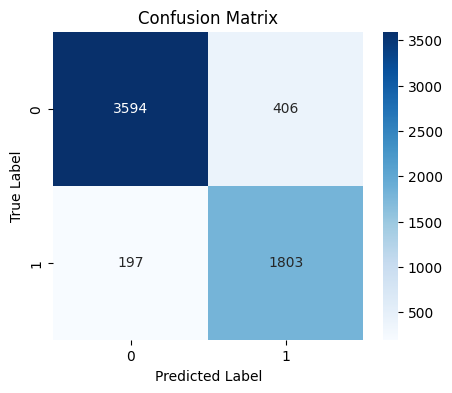


Classification Report:

              precision    recall  f1-score   support

           0     0.9480    0.8985    0.9226      4000
           1     0.8162    0.9015    0.8567      2000

    accuracy                         0.8995      6000
   macro avg     0.8821    0.9000    0.8897      6000
weighted avg     0.9041    0.8995    0.9006      6000

AUC-ROC Score: 0.9595


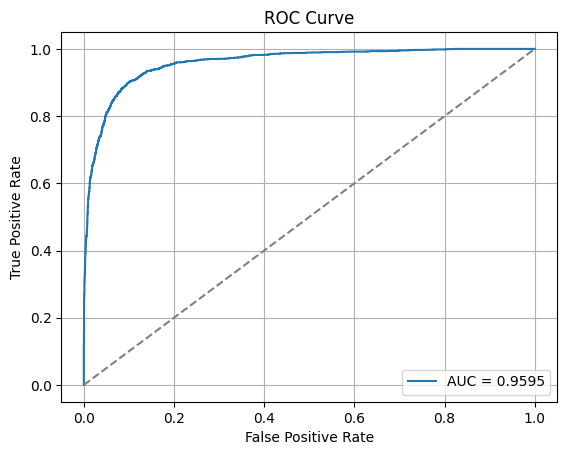

In [21]:
# Get predictions from validation/test set
true_labels, pred_labels, pred_probs = get_predictions(model, val_loader, device)

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("\nClassification Report:\n")
print(classification_report(true_labels, pred_labels, digits=4))

# AUC-ROC Score
auc = roc_auc_score(true_labels, pred_probs)
print(f"AUC-ROC Score: {auc:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(true_labels, pred_probs)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


In [28]:
import torch

# Assume these are your label names:
label_map = {0: "Not Hate", 1: "Hate"}

def predict_hate_speech(text, tokenizer, model, device):
    model.eval()
    with torch.no_grad():
        inputs = tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=128
        )
        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1).item()
        prediction = label_map[preds]
        return prediction

# Example: A dictionary with some known sentences and their actual labels
# Replace or extend this with your actual test data as needed
known_sentences = {
    "যত্তসব পাপন শালার ফাজলামী!!!!!": "Hate",
    "আজকে অনেক ভালো লাগছে": "Not Hate",
    "তুমি আজকে খুব ভালো লাগছো।": "Hate",
    "তুই বোকা আর মূর্খ, কেউ তোর কথা শোনে না": "Hate",
    # add more sentences if you want
}

while True:
    text = input("Enter a Bengali sentence (or 'exit' to quit): ")
    if text.lower() == 'exit':
        break

    pred = predict_hate_speech(text, tokenizer, model, device)
    print(f"Prediction: {pred}")

    actual = known_sentences.get(text, "Actual label unknown")
    print(f"Actual: {actual}\n")


Enter a Bengali sentence (or 'exit' to quit): যত্তসব পাপন শালার ফাজলামী!!!!!
Prediction: Hate
Actual: Hate

Enter a Bengali sentence (or 'exit' to quit): আজকে অনেক ভালো লাগছে
Prediction: Not Hate
Actual: Not Hate

Enter a Bengali sentence (or 'exit' to quit): তুমি আজকে খুব ভালো লাগছো।
Prediction: Not Hate
Actual: Hate

Enter a Bengali sentence (or 'exit' to quit): তুই বোকা আর মূর্খ, কেউ তোর কথা শোনে না
Prediction: Not Hate
Actual: Hate

Enter a Bengali sentence (or 'exit' to quit): exit


In [25]:
best_val_acc = 0
epochs = 5

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    train_acc, train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    print(f"Train loss: {train_loss:.4f}, Train accuracy: {train_acc:.4f}")

    val_acc, val_loss, val_prec, val_rec, val_f1 = eval_model(model, val_loader, criterion, device)
    print(f"Val loss: {val_loss:.4f}, Val accuracy: {val_acc:.4f}, Val precision: {val_prec:.4f}, Val recall: {val_rec:.4f}, Val F1: {val_f1:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pt')
        print(f"Best model saved at epoch {epoch+1} with val accuracy {val_acc:.4f}")


Epoch 1/5


100%|██████████| 1500/1500 [10:15<00:00,  2.44it/s]


Train loss: 0.1212, Train accuracy: 0.9557


100%|██████████| 375/375 [00:47<00:00,  7.96it/s]


Val loss: 0.3575, Val accuracy: 0.9037, Val precision: 0.8566, Val recall: 0.8540, Val F1: 0.8553
Best model saved at epoch 1 with val accuracy 0.9037
Epoch 2/5


100%|██████████| 1500/1500 [10:15<00:00,  2.44it/s]


Train loss: 0.1063, Train accuracy: 0.9610


100%|██████████| 375/375 [00:47<00:00,  7.97it/s]


Val loss: 0.3619, Val accuracy: 0.8998, Val precision: 0.8187, Val recall: 0.8985, Val F1: 0.8567
Epoch 3/5


100%|██████████| 1500/1500 [10:14<00:00,  2.44it/s]


Train loss: 0.0930, Train accuracy: 0.9677


100%|██████████| 375/375 [00:46<00:00,  7.98it/s]


Val loss: 0.3897, Val accuracy: 0.8962, Val precision: 0.8053, Val recall: 0.9080, Val F1: 0.8536
Epoch 4/5


100%|██████████| 1500/1500 [10:14<00:00,  2.44it/s]


Train loss: 0.0855, Train accuracy: 0.9707


100%|██████████| 375/375 [00:47<00:00,  7.96it/s]


Val loss: 0.3610, Val accuracy: 0.8943, Val precision: 0.8133, Val recall: 0.8865, Val F1: 0.8483
Epoch 5/5


100%|██████████| 1500/1500 [10:15<00:00,  2.44it/s]


Train loss: 0.0808, Train accuracy: 0.9726


100%|██████████| 375/375 [00:47<00:00,  7.93it/s]

Val loss: 0.3844, Val accuracy: 0.9037, Val precision: 0.8363, Val recall: 0.8840, Val F1: 0.8595


In [26]:
# Load the best model
model.load_state_dict(torch.load('best_model.pt'))
model.eval()


MBertLSTM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af